# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [2]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [3]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [4]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5
def compute_acc_prec_recall(y_hat, y_true):
    eps = 1e-12
    n = len(y_hat)
    TP = np.sum(y_hat & y_true)
    FP = np.sum(y_hat & (1-y_true))
    TN = np.sum((1-y_hat) & (1-y_true))
    FN = np.sum((1-y_hat) & y_true)
    assert n == TP + FP + TN + FN
    acc = (TP + TN) / n
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    return {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "FPR": FP / (TN + FP + eps),
    }

eval_full = compute_acc_prec_recall(ypred_full, yf_test)
eval_reduced = compute_acc_prec_recall(ypred_reduced, yr_test)
df_eval = pd.DataFrame([eval_full, eval_reduced], index=["full", "reduced"])
df_eval

,acc,precision,recall,FPR
full,0.723333,0.733333,0.678082,0.233766
reduced,0.716667,0.736434,0.650685,0.220779


## 4) Plot ROC and Precision–Recall Curves

In [5]:
# TODO: Plot ROC and PR curves for both models on shared axes
def compute_ROC_PR(y_prob, y_true, thr_list):
    precision_list = []
    recall_list = []
    FPR_list = []
    for thr in thr_list:
        y_hat = (y_prob >= thr).astype(int)
        eval_dict = compute_acc_prec_recall(y_hat, y_true)
        precision_list.append(eval_dict["precision"])
        recall_list.append(eval_dict["recall"])
        FPR_list.append(eval_dict["FPR"])
    return {
        "precision_list": precision_list,
        "recall_list": recall_list,
        "FPR_list": FPR_list,
    }
thr_list = np.arange(0, 1.00, 0.01)
ROC_PR_full = compute_ROC_PR(yprob_full, yf_test, thr_list)
ROC_PR_reduced = compute_ROC_PR(yprob_reduced, yr_test, thr_list)

Text(0, 0.5, 'Precision')

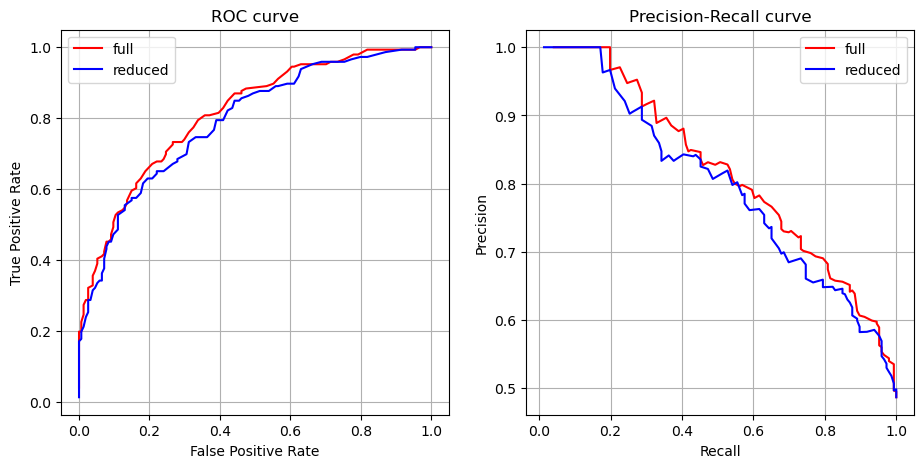

In [6]:
fig = plt.figure(figsize = (11, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eval_list = [ROC_PR_full, ROC_PR_reduced]
labels = ["full", "reduced"]
colors = ["red", "blue"]
for eval_dict, label, color in zip(eval_list, labels, colors):
    ax1.plot(eval_dict["FPR_list"], eval_dict["recall_list"], label = label, color = color)
    ax2.plot(eval_dict["recall_list"], eval_dict["precision_list"], label = label, color = color)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax1.set_title("ROC curve")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax2.set_title("Precision-Recall curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?

   <span style="color:red">The Model A (full) has higher ROC-AUC and PR-AUC, indicating that adding `PWAT` improves the model’s ability to reduce both false alarms and missed detections of the event.</span>
3. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?
   - Which model would you choose to **minimize false alarms** (precision)?

    <span style="color:red"> For the threshold of 0.5, Model A (full) has a higher recall (advantageous for maximizing event detection), while Model B (reduced) shows a slightly higher precision (advantageous for minimizing false alarms). However, at most other thresholds, Model A also achieves higher precision than Model B (see figure below). Overall, Model A is a better choice than Model B. </span>

Text(0, 0.5, 'Recall')

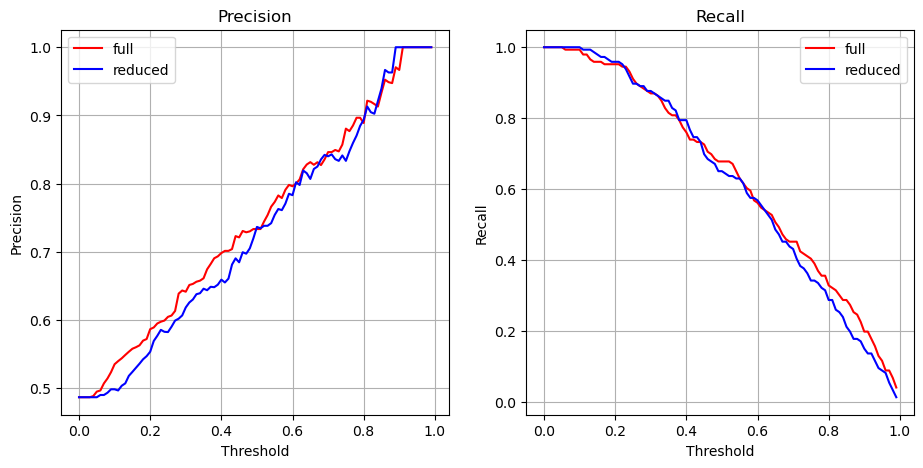

In [7]:
fig = plt.figure(figsize = (11, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
labels = ["full", "reduced"]
colors = ["red", "blue"]
for eval_dict, label, color in zip(eval_list, labels, colors):
    ax1.plot(thr_list, eval_dict["precision_list"], label = label, color = color)
    ax2.plot(thr_list, eval_dict["recall_list"], label = label, color = color)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax1.set_title("Precision")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Precision")
ax2.set_title("Recall")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Recall")